# Convolutional Neural Networks with PyTorch

In this lab, we'll explore the fundamentals of Convolutional Neural Networks (CNNs) using PyTorch. We'll cover:

1. Understanding the basics of convolution operations
2. Implementing convolution from scratch using PyTorch
3. Using PyTorch's built-in `nn.Conv2d` and related layers
4. Building and training a complete CNN model on the MNIST dataset

# Articles to read

https://poloclub.github.io/cnn-explainer/   <--- interactive explanation 

https://medium.com/thedeephub/convolutional-neural-networks-a-comprehensive-guide-5cc0b5eae175 

https://en.wikipedia.org/wiki/Convolutional_neural_network

https://www.pinecone.io/learn/series/image-search/cnn/

In [81]:
# %%
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import time

In [2]:
# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

In [3]:
# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## Part 1: Understanding Convolution Operations

### What is Convolution?

Convolution is a mathematical operation that involves sliding a filter (also called a kernel) over an input, performing element-wise multiplication at each position, and summing the results to produce an output feature map.

The key components of a convolution operation are:

- **Input**: The data to be convolved (e.g., an image)
- **Filter/Kernel**: A small matrix of weights
- **Stride**: How many positions to move the filter at each step
- **Padding**: Adding extra pixels around the input to control the output size

### Why are Convolutions used in Neural Networks?

Convolutions have several advantages for processing grid-like data (such as images):

1. **Parameter Sharing**: The same filter is applied across the entire input, reducing the number of parameters compared to fully connected layers.
2. **Spatial Hierarchy**: By stacking convolution layers, the network can learn hierarchical features (edges → shapes → objects).
3. **Translation Invariance**: The same features can be detected regardless of their position in the input.
4. **Local Connectivity**: Each output value depends only on a small local region of the input, preserving spatial relationships.

### Let's visualize how a convolution operation works

In [4]:
# Create a simple 6x6 input
input_data = torch.zeros(6, 6)
input_data[1:5, 1:5] = torch.ones(4, 4)  # Create a white square on black background
input_data[2:4, 2:4] = torch.zeros(2, 2)  # With a black square inside

In [5]:
# Create a 3x3 edge detection kernel
kernel = torch.tensor([[-1, -1, -1],
                       [-1,  8, -1],
                       [-1, -1, -1]], dtype=torch.float32)

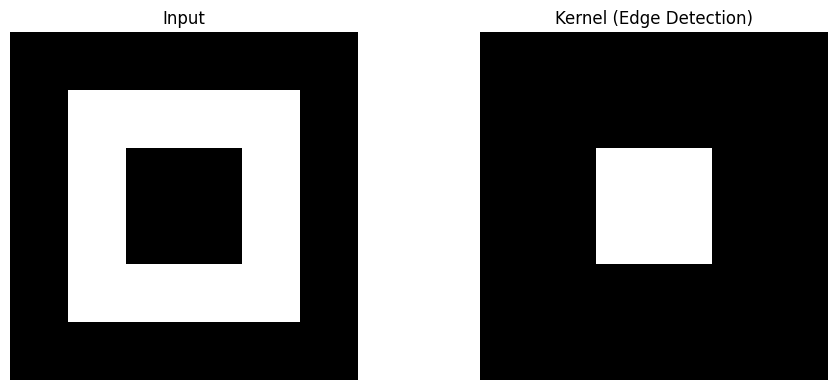

In [6]:
# Display the input and kernel
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
#@TODO
axes[0].imshow(..., cmap='gray')
axes[0].set_title('Input')
axes[0].axis('off')

axes[1].imshow(..., cmap='gray')
axes[1].set_title('Kernel (Edge Detection)')
axes[1].axis('off')

plt.tight_layout()
plt.show()

### Visualizing the Convolution Process

Let's visualize the convolution operation step by step to understand how it works:

In [7]:
# %%
# Function to perform a manual convolution
def manual_convolution(input_data, kernel):
    # Get dimensions
    input_h, input_w = input_data.shape
    kernel_h, kernel_w = kernel.shape
    
    # Calculate output dimensions (assuming no padding and stride=1)
    output_h = input_h - kernel_h + 1
    output_w = input_w - kernel_w + 1
    
    # Initialize output
    output = torch.zeros(output_h, output_w)
    
    # Perform convolution
    for i in range(output_h):
        for j in range(output_w):
            # Extract the region from input
            #@TODO
            region = input_data[i:i+..., j:j+...]
            # Element-wise multiplication and sum
            output[i, j] = torch.sum(region * kernel)
    
    return output

In [8]:
# Apply manual convolution
output = manual_convolution(input_data, kernel)

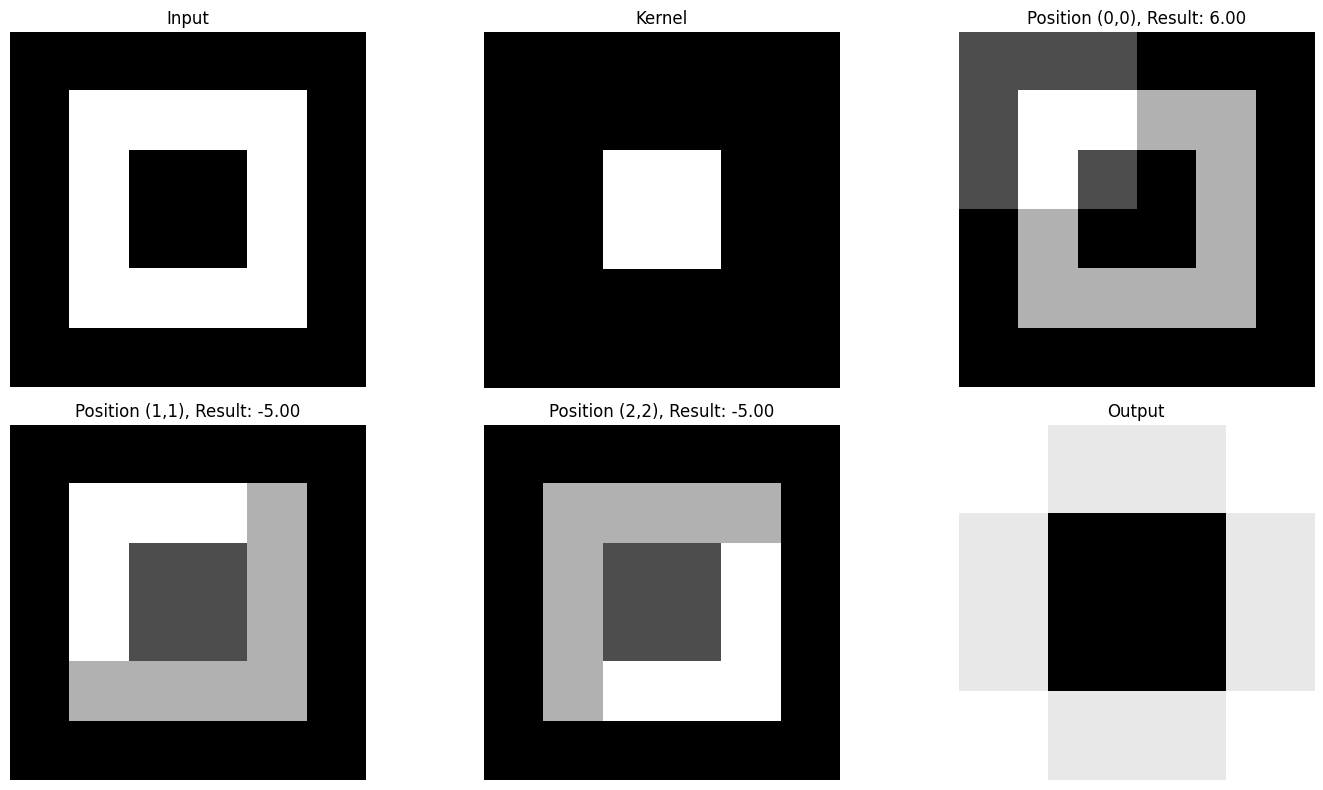

In [9]:
# %%
# Visualize step-by-step convolution
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

# Display input and kernel
axes[0].imshow(input_data, cmap='gray')
axes[0].set_title('Input')
axes[0].axis('off')

axes[1].imshow(kernel, cmap='gray')
axes[1].set_title('Kernel')
axes[1].axis('off')

# Visualize a few steps of the convolution
positions = [(0, 0), (1, 1), (2, 2)]
for idx, (i, j) in enumerate(positions, 2):
    # Create a visualization of the current step
    vis = torch.zeros_like(input_data)
    vis[i:i+3, j:j+3] = 0.5  # Highlight the region being convolved
    
    # Extract the region
    region = input_data[i:i+3, j:j+3]
    
    # Calculate the result for this position
    # @TODO 
    result = torch.sum(...).item()
    
    # Display the visualization
    axes[idx].imshow(vis, cmap='gray')
    axes[idx].imshow(input_data, cmap='gray', alpha=0.7)
    axes[idx].set_title(f'Position ({i},{j}), Result: {result:.2f}')
    axes[idx].axis('off')

# Display final output
axes[5].imshow(output, cmap='gray')
axes[5].set_title('Output')
axes[5].axis('off')

plt.tight_layout()
plt.show()

## Part 2: Implementing Convolution from Scratch

Now, let's implement a simple convolutional layer from scratch using PyTorch's low-level operations.

In [10]:
# %%
# Custom Convolution Layer
class CustomConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0):
        super(CustomConv2d, self).__init__()
        
        # Initialize parameters
        #@TODO
        self.in_channels = ...
        self.out_channels = ...
        self.kernel_size = ...
        self.stride = ...
        self.padding = ...
        
        # Create weight parameters
        # Shape: (out_channels, in_channels, kernel_size, kernel_size)
        # @TODO
        self.weight = nn.Parameter(
            torch.randn(...) * 0.01
        )
        
        # Create bias parameters
        # Shape: (out_channels)
        # @TODO
        self.bias = nn.Parameter(torch.zeros(...))
        
    def forward(self, x):
        batch_size, in_channels, height, width = x.shape
        
        # Apply padding if specified
        if self.padding > 0:
            x = F.pad(x, (self.padding, self.padding, self.padding, self.padding))
        
        # Calculate output dimensions
        # @TODO
        out_height = (...) // self.stride + 1
        out_width = (...) // self.stride + 1
        
        # Initialize output tensor
        output = torch.zeros(batch_size, self.out_channels, out_height, out_width, device=x.device)
        
        # Perform convolution for each sample in the batch
        for b in range(batch_size):
            for c_out in range(self.out_channels):
                for h in range(0, out_height):
                    h_pos = h * self.stride
                    for w in range(0, out_width):
                        w_pos = w * self.stride
                        # Extract the region from input
                        #@TODO
                        region = x[b, :, h_pos:h_pos+..., w_pos:w_pos+...]
                        # Apply convolution
                        # @TODO
                        output[b, c_out, h, w] = torch.sum(... * self.weight[...]) + ...[c_out]
        
        return output

Let's test our custom convolution implementation on a small input and compare it with PyTorch's built-in convolution.

In [ ]:
# %%
# Create a test input
batch_size = 2
in_channels = 3
height = 32
width = 32
x = torch.randn(batch_size, in_channels, height, width)

In [12]:
# Create instances of our custom and PyTorch's convolution
# input channels: 3, out channels 16, kernel 3, stride 1, padding 1
# @TODO
custom_conv = CustomConv2d(..)
torch_conv = nn.Conv2d(...)

In [13]:
# Copy weights from custom to torch convolution for fair comparison
with torch.no_grad():
    torch_conv.weight.copy_(custom_conv.weight)
    torch_conv.bias.copy_(custom_conv.bias)

In [14]:
# Forward pass through both layers
custom_output = custom_conv(x)
torch_output = torch_conv(x)

In [15]:
# Compare outputs
diff = torch.abs(custom_output - torch_output).mean().item()
print(f"Average absolute difference: {diff:.6f}")

Average absolute difference: 0.000000


In [16]:
# Get shapes
print(f"Input shape: {x.shape}")
print(f"Custom output shape: {custom_output.shape}")
print(f"PyTorch output shape: {torch_output.shape}")

Input shape: torch.Size([2, 3, 32, 32])
Custom output shape: torch.Size([2, 16, 32, 32])
PyTorch output shape: torch.Size([2, 16, 32, 32])


## Part 3: Using PyTorch's Built-in Convolutional Layers

PyTorch provides efficient implementations of convolutional layers and related operations through the `nn` module. Let's explore these.

In [17]:
# %%
# Convolutional Layer (nn.Conv2d)
# @TODO
conv_layer = nn.Conv2d(
    ...       # Number of input channels (e.g., RGB has 3 channels)
    ...     # Number of output channels (filters) (look at output)
    ...       # Size of the convolutional kernel (3×3)
    stride=1,            # Step size when sliding the kernel
    padding=1,           # Zero-padding around the input
    bias=True            # Whether to include a bias term
)

In [18]:
# Display the layer parameters
print(f"Layer: {conv_layer}")
print(f"Weight shape: {conv_layer.weight.shape}")
print(f"Bias shape: {conv_layer.bias.shape}")
print(f"Number of parameters: {sum(p.numel() for p in conv_layer.parameters())}")

Layer: Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Weight shape: torch.Size([16, 3, 3, 3])
Bias shape: torch.Size([16])
Number of parameters: 448


### Other Important Layers in CNNs

In addition to convolutional layers, CNNs typically use several other types of layers:

1. **Pooling Layers** - Reduce spatial dimensions
2. **Activation Functions** - Introduce non-linearity
3. **Batch Normalization** - Stabilize and accelerate training
4. **Fully Connected Layers** - Connect all neurons for final classification

Let's explore each of these:

In [19]:
# %%
# 1. Pooling Layers
# @TODO
maxpool = nn....(kernel_size=2, stride=2)  # Max pooling
avgpool = nn....(kernel_size=2, stride=2)  # Average pooling

In [20]:
# 2. Activation Functions
# @TODO
relu = nn....()                    # Rectified Linear Unit
leaky_relu = nn....(0.1)      # Leaky ReLU
sigmoid = nn...()              # Sigmoid function

In [21]:
# 3. Batch Normalization
# @TODO
batchnorm = nn....(16)      # Batch normalization for 16 channels

In [22]:
# 4. Fully Connected (Linear) Layer
# @TODO
fc = nn....(in_features=16*16*16, out_features=10)  # Connecting to 10 output classes

In [23]:
# Let's see how these layers transform the data
test_input = torch.randn(1, 3, 32, 32)  # (batch_size, channels, height, width)

In [ ]:
# @TODO
conv_out = conv_layer(...)
relu_out = relu(...)
bn_out = batchnorm(...)
pool_out = maxpool(...)

In [25]:
print(f"Input shape: {test_input.shape}")
print(f"After Conv2d: {conv_out.shape}")
print(f"After ReLU: {relu_out.shape}")
print(f"After BatchNorm: {bn_out.shape}")
print(f"After MaxPool: {pool_out.shape}")

Input shape: torch.Size([1, 3, 32, 32])
After Conv2d: torch.Size([1, 16, 32, 32])
After ReLU: torch.Size([1, 16, 32, 32])
After BatchNorm: torch.Size([1, 16, 32, 32])
After MaxPool: torch.Size([1, 16, 16, 16])


In [26]:
# To use a fully connected layer, we need to flatten the output
flattened = pool_out.view(1, -1)  # Reshape to (batch_size, features)
print(f"After flattening: {flattened.shape}")

After flattening: torch.Size([1, 4096])


In [27]:
fc_out = fc(flattened)
print(f"After Linear layer: {fc_out.shape}")

After Linear layer: torch.Size([1, 10])


### Visualizing Different Types of Convolutional Layers

Let's visualize the effects of different convolutional operations on a sample image:

In [28]:
# %%
# Load a sample image
transform = transforms.Compose([
    transforms.ToTensor(),
])
mnist_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
sample_image, _ = mnist_dataset[0]  # Get the first image

In [29]:
# Add batch dimension
sample_image = sample_image.unsqueeze(0)  # Shape: (1, 1, 28, 28)

In [30]:
# Define different convolutional filters
# @TODO
filters = {
    'Original': None,
    'Horizontal Edges': torch.tensor(...).float().view(1, 1, 3, 3).to(device),
    'Vertical Edges': torch.tensor(...).float().view(1, 1, 3, 3).to(device),
    'Sharpen': torch.tensor(...).float().view(1, 1, 3, 3).to(device),
    'Blur': torch.tensor(...).float().view(1, 1, 3, 3).to(device) / 9,
    'Emboss': torch.tensor([[-2, -1, 0], [-1, 1, 1], [0, 1, 2]]).float().view(1, 1, 3, 3).to(device)
}

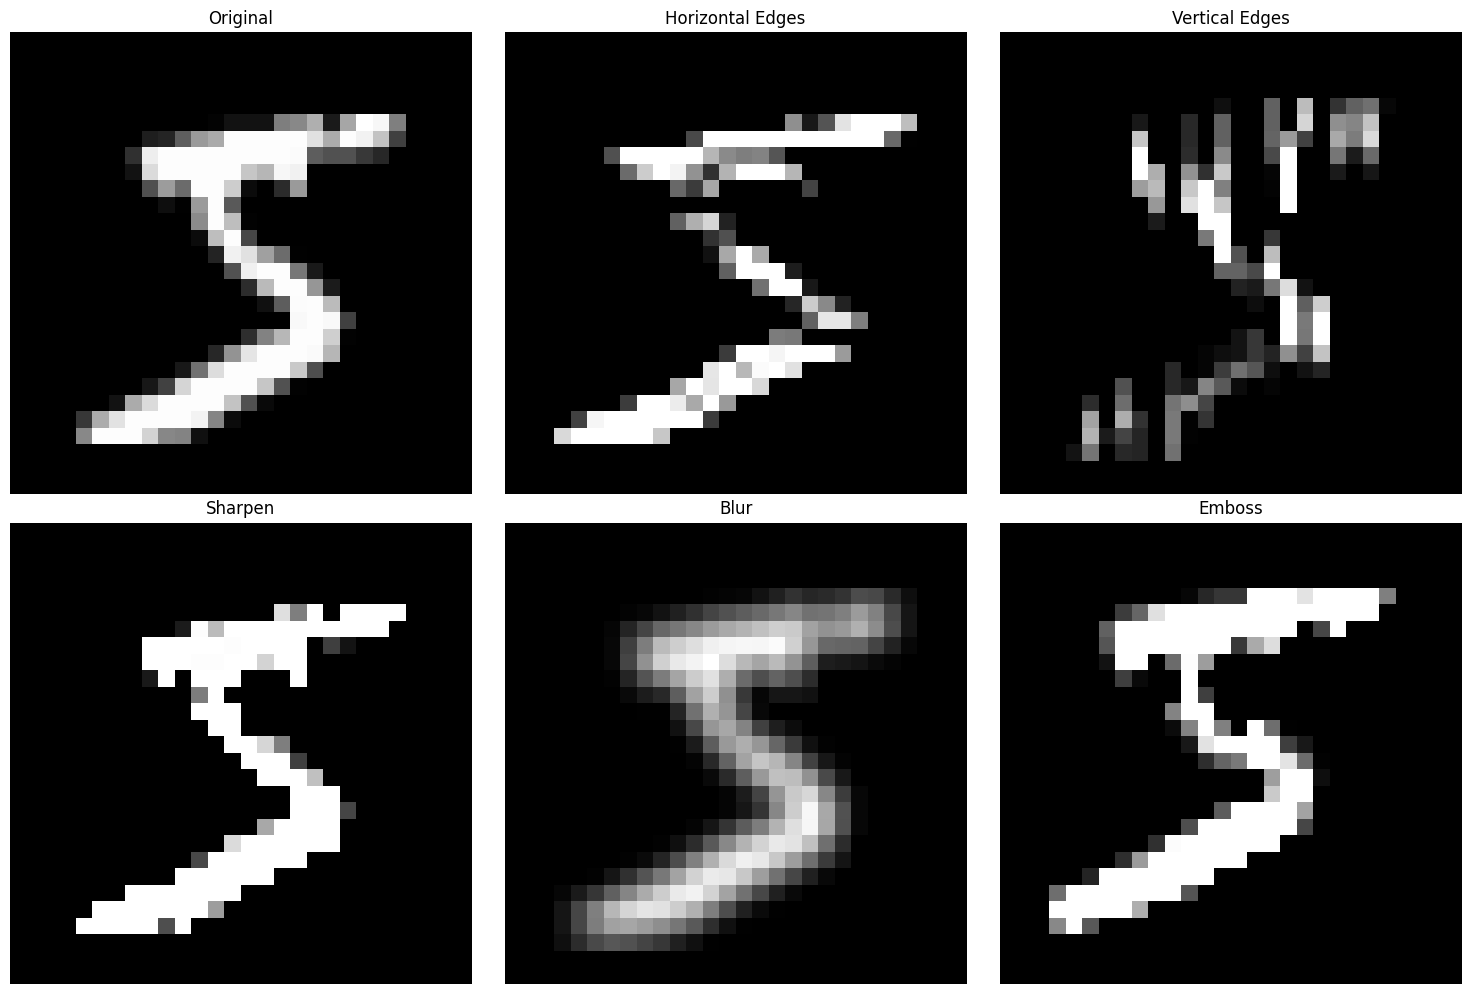

In [31]:
# Apply filters and visualize results
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, (name, filter_weights) in enumerate(filters.items()):
    if filter_weights is None:  # Original image
        output = sample_image
    else:
        # Create a convolutional layer with the predefined weights
        filter_layer = nn.Conv2d(1, 1, kernel_size=3, padding=1, bias=False)
        filter_layer.weight.data = filter_weights
        
        # Apply the filter
        with torch.no_grad():
            output = filter_layer(sample_image.to(device))
    
    # Ensure output is in valid range for display
    output = torch.clamp(output, 0, 1)
    
    # Remove batch and channel dimensions for display
    img_to_show = output.squeeze().cpu().numpy()
    
    # Plot
    axes[i].imshow(img_to_show, cmap='gray')
    axes[i].set_title(name)
    axes[i].axis('off')

plt.tight_layout()
plt.show()

## Part 4: Building a Complete CNN Model

Now that we understand the building blocks, let's implement a complete CNN architecture for image classification.

We'll create a model with:
- Multiple convolutional layers
- Max pooling layers
- ReLU activations
- Batch normalization
- Fully connected (linear) layers

Then we'll train it on the MNIST dataset of handwritten digits.

In [32]:
# %%
# Define a simple CNN model for MNIST
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        
        # First convolutional block
        # @TODO conv, batch norm, relu, pool
        self.conv1 = nn....(..., ..., kernel_size=3, padding=1)
        self.bn1 = nn....(32)
        self.relu1 = ...
        self.pool1 = ...
        
        # Second convolutional block
        # @TODO conv, brtach norm, relu, pool
        self.conv2 = ...
        self.bn2 = ...
        self.relu2 = ...
        self.pool2 = ..
        
        # Fully connected layers
        # @TODO fully connected
        self.fc1 = nn....(..., 128)
        self.relu3 = nn.ReLU()
        self.dropout = nn.Dropout(0.5)  # Dropout for regularization
        self.fc2 = nn....(128, ...)
    
    def forward(self, x):
        # First block
        # @TODO
        x = ...
        x = ...
        x = ...
        x = ...
        
        # Second block
        # @TODO
        x = ...
        x = ...
        x = ...
        x = ...
        
        # Flatten the output for the fully connected layer
        x = x.view(x.size(0), -1)
        
        # Fully connected layers
        # @TODO
        x = ...
        x = ...
        x = ...
        x = ...
        
        return x

In [33]:
# Create the model and move it to the device
model = SimpleCNN().to(device)
print(model)

SimpleCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (relu3): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


In [34]:
# Calculate the number of parameters
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Number of trainable parameters: {num_params}")

Number of trainable parameters: 421834


### Architecture Visualization

Let's visualize the architecture of our CNN to understand how the data flows through the network and how the dimensions change at each layer.

In [35]:
# %%
# Trace the data flow through the model for a single image
test_input = torch.randn(1, 1, 28, 28).to(device)  # Test with one MNIST image
layer_outputs = []

In [36]:
# Manually trace outputs at each layer
x = test_input
layer_outputs.append(("Input", x.shape))

In [37]:
# First block
x = model.conv1(x)
layer_outputs.append(("Conv1", x.shape))
x = model.bn1(x)
layer_outputs.append(("BatchNorm1", x.shape))
x = model.relu1(x)
layer_outputs.append(("ReLU1", x.shape))
x = model.pool1(x)
layer_outputs.append(("MaxPool1", x.shape))

In [38]:
# Second block
x = model.conv2(x)
layer_outputs.append(("Conv2", x.shape))
x = model.bn2(x)
layer_outputs.append(("BatchNorm2", x.shape))
x = model.relu2(x)
layer_outputs.append(("ReLU2", x.shape))
x = model.pool2(x)
layer_outputs.append(("MaxPool2", x.shape))

In [39]:
# Flatten
x_flat = x.view(x.size(0), -1)
layer_outputs.append(("Flatten", x_flat.shape))

In [40]:
# Fully connected layers
x = model.fc1(x_flat)
layer_outputs.append(("FC1", x.shape))
x = model.relu3(x)
layer_outputs.append(("ReLU3", x.shape))
x = model.dropout(x)
layer_outputs.append(("Dropout", x.shape))
x = model.fc2(x)
layer_outputs.append(("FC2 (Output)", x.shape))

In [41]:
# Create a visualization of the architecture
for i, (name, shape) in enumerate(layer_outputs):
    print(f"{name}: {shape}")

Input: torch.Size([1, 1, 28, 28])
Conv1: torch.Size([1, 32, 28, 28])
BatchNorm1: torch.Size([1, 32, 28, 28])
ReLU1: torch.Size([1, 32, 28, 28])
MaxPool1: torch.Size([1, 32, 14, 14])
Conv2: torch.Size([1, 64, 14, 14])
BatchNorm2: torch.Size([1, 64, 14, 14])
ReLU2: torch.Size([1, 64, 14, 14])
MaxPool2: torch.Size([1, 64, 7, 7])
Flatten: torch.Size([1, 3136])
FC1: torch.Size([1, 128])
ReLU3: torch.Size([1, 128])
Dropout: torch.Size([1, 128])
FC2 (Output): torch.Size([1, 10])


### Preparing the MNIST Dataset

In [42]:
# %%
# Define the transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))  # MNIST mean and std
])

In [43]:
# Load the MNIST dataset
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

In [44]:
# Create data loaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [45]:
print(f"Training set size: {len(train_dataset)}")
print(f"Test set size: {len(test_dataset)}")

Training set size: 60000
Test set size: 10000


In [46]:
# Visualize some sample images
examples = iter(train_loader)
samples, labels = next(examples)

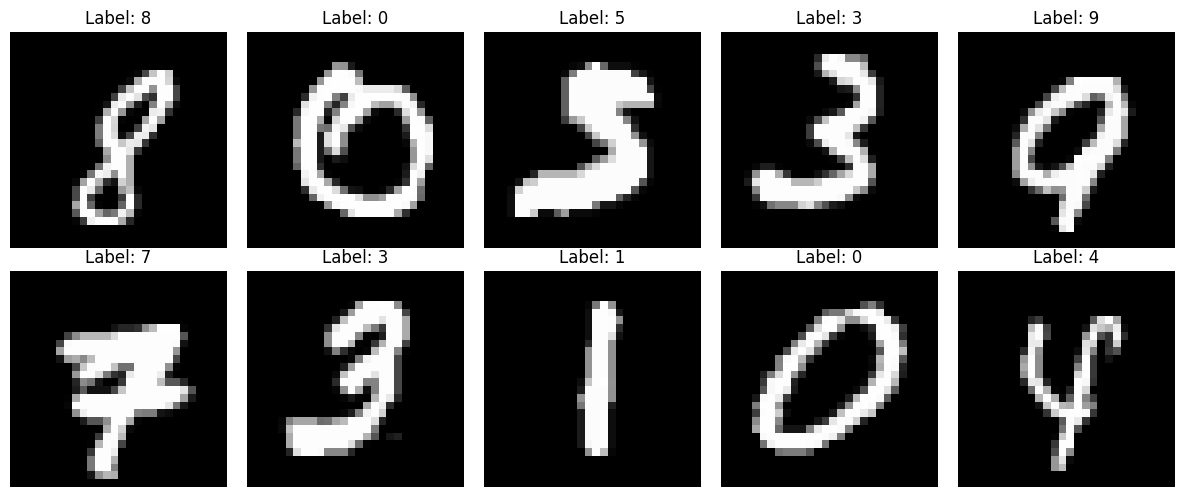

In [47]:
# Plot a few samples
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
axes = axes.flatten()

for i in range(10):
    img = samples[i][0]  # First channel
    axes[i].imshow(img, cmap='gray')
    axes[i].set_title(f'Label: {labels[i].item()}')
    axes[i].axis('off')

plt.tight_layout()
plt.show()

### Training the CNN Model

Now, let's train our CNN model on the MNIST dataset.

In [48]:
# %%
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [49]:
# Training loop
def train(model, train_loader, criterion, optimizer, device):
    #@TODO
    ...  # Set the model to training mode
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        # Zero the parameter gradients
        #@TODO
        ...
        
        # Forward pass
        #@TODO
        ...
        loss = criterion(outputs, labels)
        
        # Backward pass and optimize
        #@TODO
        ...
        ...
        
        # Track statistics
        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

In [50]:
# Evaluation function
def evaluate(model, test_loader, criterion, device):
    model.eval()  # Set the model to evaluation mode
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():  # No need to track gradients during evaluation
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            
            # Forward pass
            #@TODO
            ...
            ...
            
            # Track statistics
            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

In [51]:
# Train the model
num_epochs = 5
train_losses = []
train_accs = []
test_losses = []
test_accs = []

for epoch in range(num_epochs):
    start_time = time.time()
    
    # Train for one epoch
    train_loss, train_acc = train(model, train_loader, criterion, optimizer, device)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    
    # Evaluate on the test set
    test_loss, test_acc = evaluate(model, test_loader, criterion, device)
    test_losses.append(test_loss)
    test_accs.append(test_acc)
    
    # Print statistics
    time_elapsed = time.time() - start_time
    print(f"Epoch {epoch+1}/{num_epochs} - {time_elapsed:.2f}s - "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
          f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")

Epoch 1/5 - 10.96s - Train Loss: 0.2295, Train Acc: 0.9301, Test Loss: 0.0601, Test Acc: 0.9813
Epoch 2/5 - 10.83s - Train Loss: 0.1082, Train Acc: 0.9678, Test Loss: 0.0387, Test Acc: 0.9871
Epoch 3/5 - 10.69s - Train Loss: 0.0874, Train Acc: 0.9745, Test Loss: 0.0381, Test Acc: 0.9870
Epoch 4/5 - 10.72s - Train Loss: 0.0755, Train Acc: 0.9771, Test Loss: 0.0266, Test Acc: 0.9916
Epoch 5/5 - 10.74s - Train Loss: 0.0630, Train Acc: 0.9806, Test Loss: 0.0321, Test Acc: 0.9908


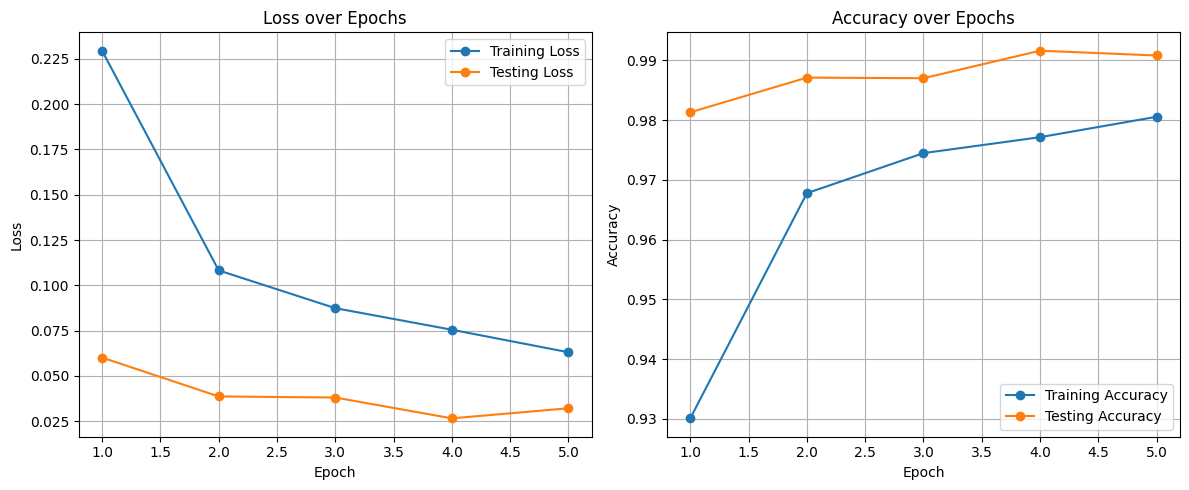

In [52]:
# Plot the training and testing curves
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_losses, marker='o', label='Training Loss')
plt.plot(range(1, num_epochs+1), test_losses, marker='o', label='Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), train_accs, marker='o', label='Training Accuracy')
plt.plot(range(1, num_epochs+1), test_accs, marker='o', label='Testing Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

### Visualizing Filters and Feature Maps

One way to understand what our CNN is learning is to visualize the convolutional filters and the feature maps they produce.

In [53]:
# %%
# Visualize the filters (weights) of the first convolutional layer
# @TODO
weights = model.....weight.data.cpu().numpy()

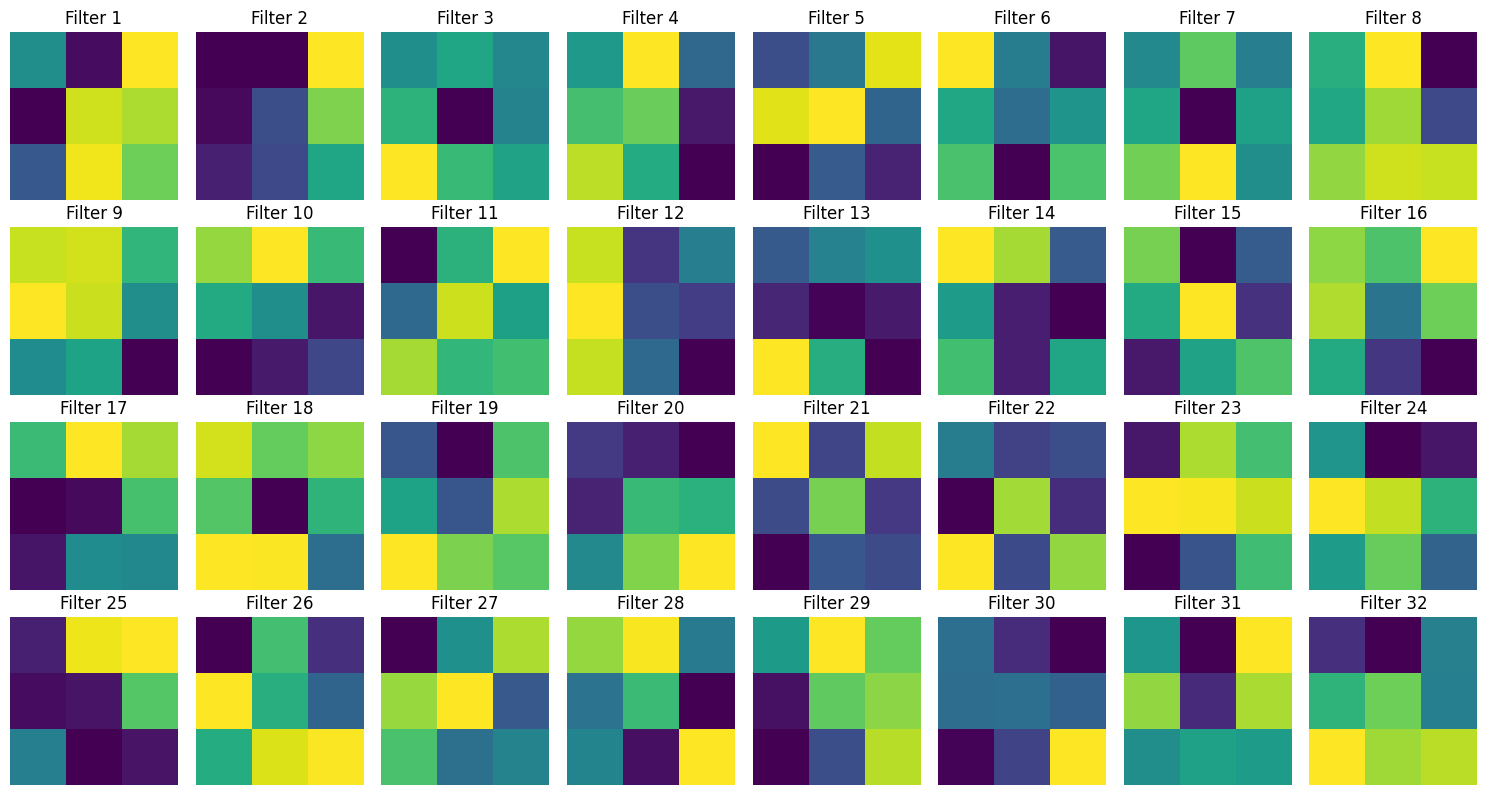

In [54]:
# Create a figure to show the filters
fig, axes = plt.subplots(4, 8, figsize=(15, 8))
axes = axes.flatten()

for i in range(min(32, len(axes))):
    # Get the i-th filter
    filter_img = weights[i, 0]
    
    # Normalize for better visualization
    filter_img = (filter_img - filter_img.min()) / (filter_img.max() - filter_img.min() + 1e-8)
    
    # Display the filter
    axes[i].imshow(filter_img, cmap='viridis')
    axes[i].set_title(f'Filter {i+1}')
    axes[i].axis('off')

plt.tight_layout()
plt.show()

### Visualizing Feature Maps

Let's also visualize the feature maps (activations) for an input image:

In [55]:
# %%
# Get a sample image
sample_batch = next(iter(test_loader))
sample_image, sample_label = sample_batch[0][0:1].to(device), sample_batch[1][0].to(device)

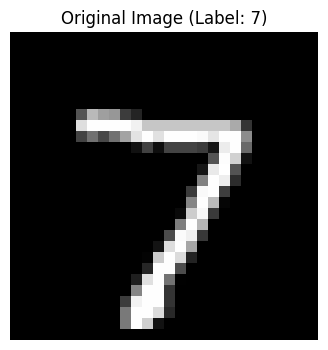

In [56]:
# Display the original image
plt.figure(figsize=(4, 4))
plt.imshow(sample_image.cpu().squeeze(), cmap='gray')
plt.title(f'Original Image (Label: {sample_label.item()})')
plt.axis('off')
plt.show()

In [57]:
# Extract feature maps from different layers
model.eval()
feature_maps = {}

In [58]:
# Hook to extract feature maps
def get_activation(name):
    def hook(model, input, output):
        feature_maps[name] = output.detach().cpu()
    return hook

In [59]:
# Register hooks
hooks = []
# @TODO
hooks.append(model.....register_forward_hook(get_activation('conv1')))
hooks.append(model.....register_forward_hook(get_activation('conv2')))

In [60]:
# Forward pass to get activations
with torch.no_grad():
    # @TODO
    output = model(...)
    _, predicted = torch.max(output.data, 1)

In [61]:
# Remove hooks
for hook in hooks:
    hook.remove()

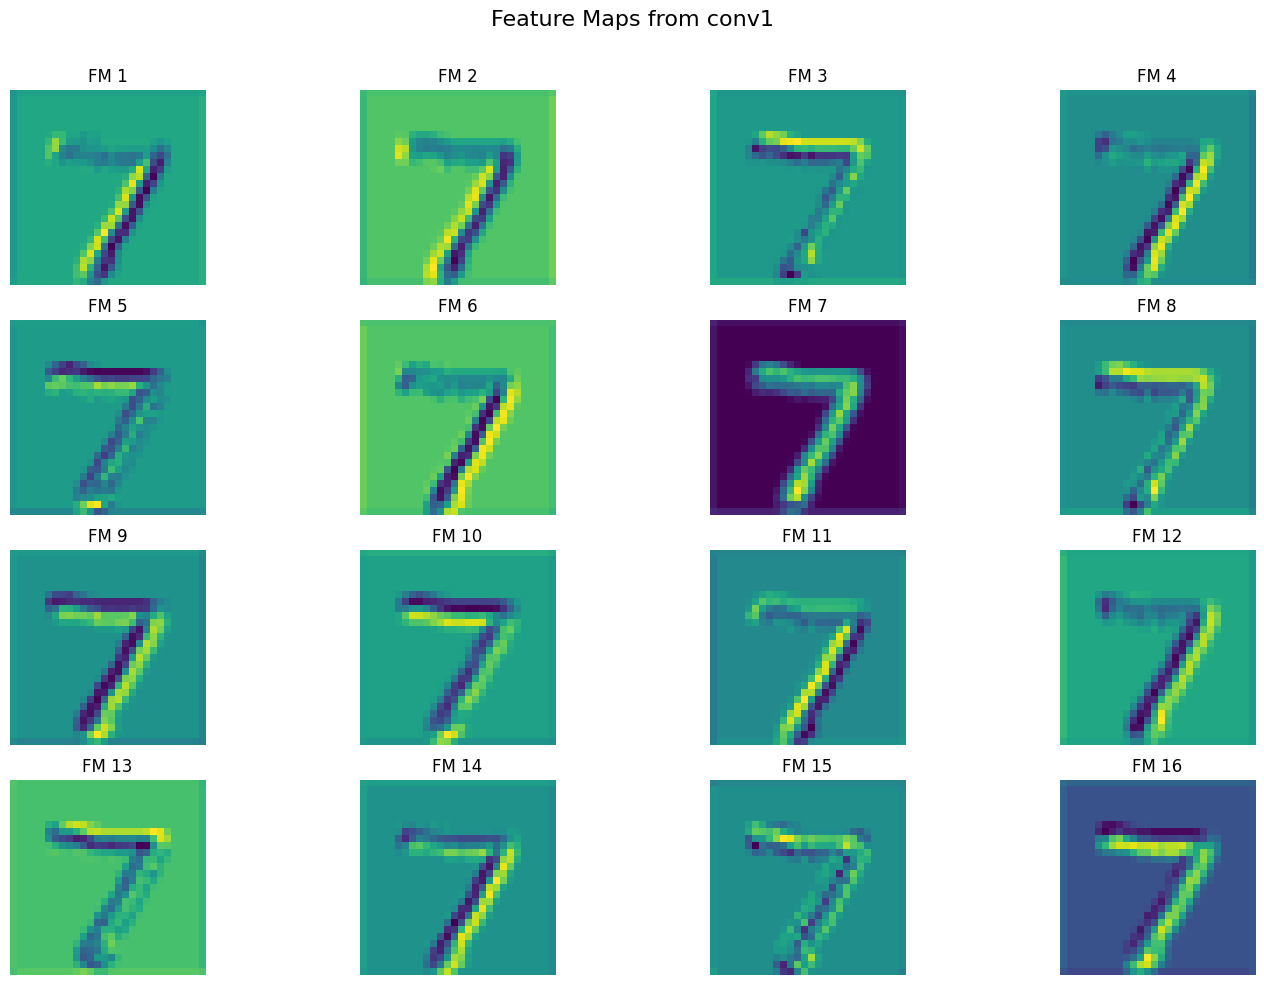

In [62]:
# Visualize feature maps from the first convolutional layer
plt.figure(figsize=(15, 10))
layer_name = 'conv1'
feature_map = feature_maps[layer_name][0]  # First sample in batch

# Normalize each feature map for better visualization
for i in range(feature_map.shape[0]):
    feature_map[i] = (feature_map[i] - feature_map[i].min()) / (feature_map[i].max() - feature_map[i].min() + 1e-8)

# Plot a subset of feature maps
num_to_plot = min(16, feature_map.shape[0])
subplot_rows = int(np.sqrt(num_to_plot))
subplot_cols = int(np.ceil(num_to_plot / subplot_rows))

for i in range(num_to_plot):
    plt.subplot(subplot_rows, subplot_cols, i+1)
    plt.imshow(feature_map[i], cmap='viridis')
    plt.title(f'FM {i+1}')
    plt.axis('off')

plt.tight_layout()
plt.suptitle(f'Feature Maps from {layer_name}', fontsize=16)
plt.subplots_adjust(top=0.9)
plt.show()

## Part 5: Comparing Different CNN Architectures

Let's compare a few different CNN architectures to see how they perform on MNIST.

In [63]:
# %%
# Define a simpler CNN model
class SimplerCNN(nn.Module):
    def __init__(self):
        super(SimplerCNN, self).__init__()
        # conv 1 8 , kernel 3, pad 1
        # @TODO
        self.conv1 = ...
        self.pool = nn.MaxPool2d(2)
        self.fc = nn.Linear(...)
        
    def forward(self, x):
        # @TODO
        x = ...(x)
        x = F.relu(x)
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = ...
        return x

In [64]:
# Define a deeper CNN model
class DeeperCNN(nn.Module):
    def __init__(self):
        super(DeeperCNN, self).__init__()
        # kernel and paddis is always 3 and 1
        # @TODO
        # Conv 1,32 -> batchnorm, -> conv 32, 32 -> batchnorm -> maxpool2d
        self.conv1 = ...
        self.bn1 = ...
        self.conv2 = ...
        self.bn2 = ...
        self.pool1 = nn.MaxPool2d(2)

        # Conv 32,64 -> batchnorm, -> conv 64, 64 -> batchnorm -> maxpool2d
        # @TODO
        self.conv3 = ...
        self.bn3 = ...
        self.conv4 = ...
        self.bn4 = ...
        self.pool2 = nn.MaxPool2d(2)
        # @TODO
        self.fc1 = nn.Linear(..., 128)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, ...)
        
    def forward(self, x):
        # @TODO you have too fill in here many lines of code, should be obvious by now how to do it
        x = ...
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [65]:
# %%
# Create instances of the models
simpler_cnn = SimplerCNN().to(device)
deeper_cnn = DeeperCNN().to(device)

In [66]:
# Print model summaries
for name, model_arch in [("Simpler CNN", simpler_cnn), ("Original CNN", model), ("Deeper CNN", deeper_cnn)]:
    num_params = sum(p.numel() for p in model_arch.parameters() if p.requires_grad)
    print(f"{name}: {num_params} parameters")

Simpler CNN: 15770 parameters
Original CNN: 421834 parameters
Deeper CNN: 468202 parameters


Let's train and compare these different models:

In [67]:
# %%
# Function to train and evaluate a model
def train_and_evaluate(model, train_loader, test_loader, epochs=3):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    train_accuracies = []
    test_accuracies = []
    
    for epoch in range(epochs):
        # Train
        train_loss, train_acc = train(model, train_loader, criterion, optimizer, device)
        train_accuracies.append(train_acc)
        
        # Evaluate
        test_loss, test_acc = evaluate(model, test_loader, criterion, device)
        test_accuracies.append(test_acc)
        
        print(f"Epoch {epoch+1}/{epochs} - "
              f"Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}")
    
    return train_accuracies, test_accuracies

In [68]:
# Train the models
print("Training Simpler CNN:")
simpler_train_accs, simpler_test_accs = train_and_evaluate(simpler_cnn, train_loader, test_loader)

Training Simpler CNN:
Epoch 1/3 - Train Acc: 0.9205, Test Acc: 0.9567
Epoch 2/3 - Train Acc: 0.9645, Test Acc: 0.9696
Epoch 3/3 - Train Acc: 0.9741, Test Acc: 0.9764


In [69]:
print("\nTraining Deeper CNN:")
deeper_train_accs, deeper_test_accs = train_and_evaluate(deeper_cnn, train_loader, test_loader)


Training Deeper CNN:
Epoch 1/3 - Train Acc: 0.9478, Test Acc: 0.9865
Epoch 2/3 - Train Acc: 0.9778, Test Acc: 0.9889
Epoch 3/3 - Train Acc: 0.9819, Test Acc: 0.9912


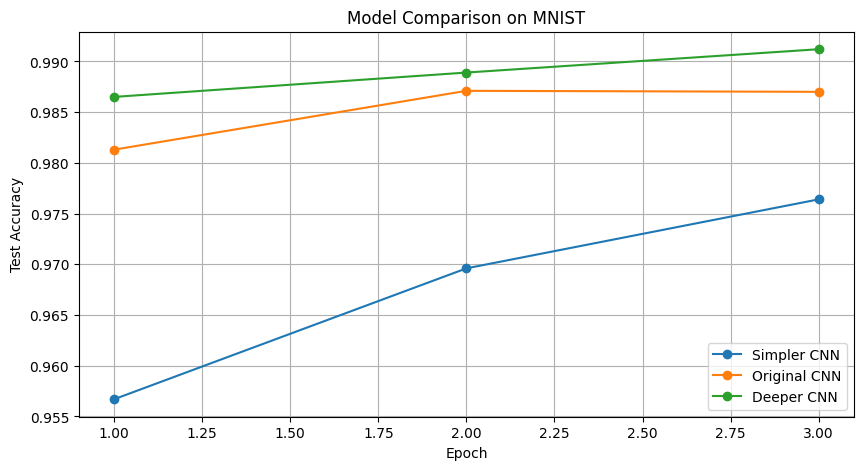

In [70]:
# Plot accuracy comparison
plt.figure(figsize=(10, 5))
epochs = range(1, len(simpler_test_accs) + 1)

plt.plot(epochs, simpler_test_accs, 'o-', label='Simpler CNN')
plt.plot(epochs, test_accs[:len(epochs)], 'o-', label='Original CNN')
plt.plot(epochs, deeper_test_accs, 'o-', label='Deeper CNN')

plt.title('Model Comparison on MNIST')
plt.xlabel('Epoch')
plt.ylabel('Test Accuracy')
plt.legend()
plt.grid(True)
plt.show()

## Part 6: Visualizing Model Predictions

In [71]:
# %%
# Select a model for visualization (the original CNN)
# @TODO
model_to_visualize = ...

In [72]:
# Get a batch of test images
dataiter = iter(test_loader)
images, labels = next(dataiter)
images, labels = images.to(device), labels.to(device)

In [73]:
# Make predictions
model_to_visualize.eval()
with torch.no_grad():
    # @TODO
    outputs = ...(images)
    _, predicted = torch....(outputs, 1)

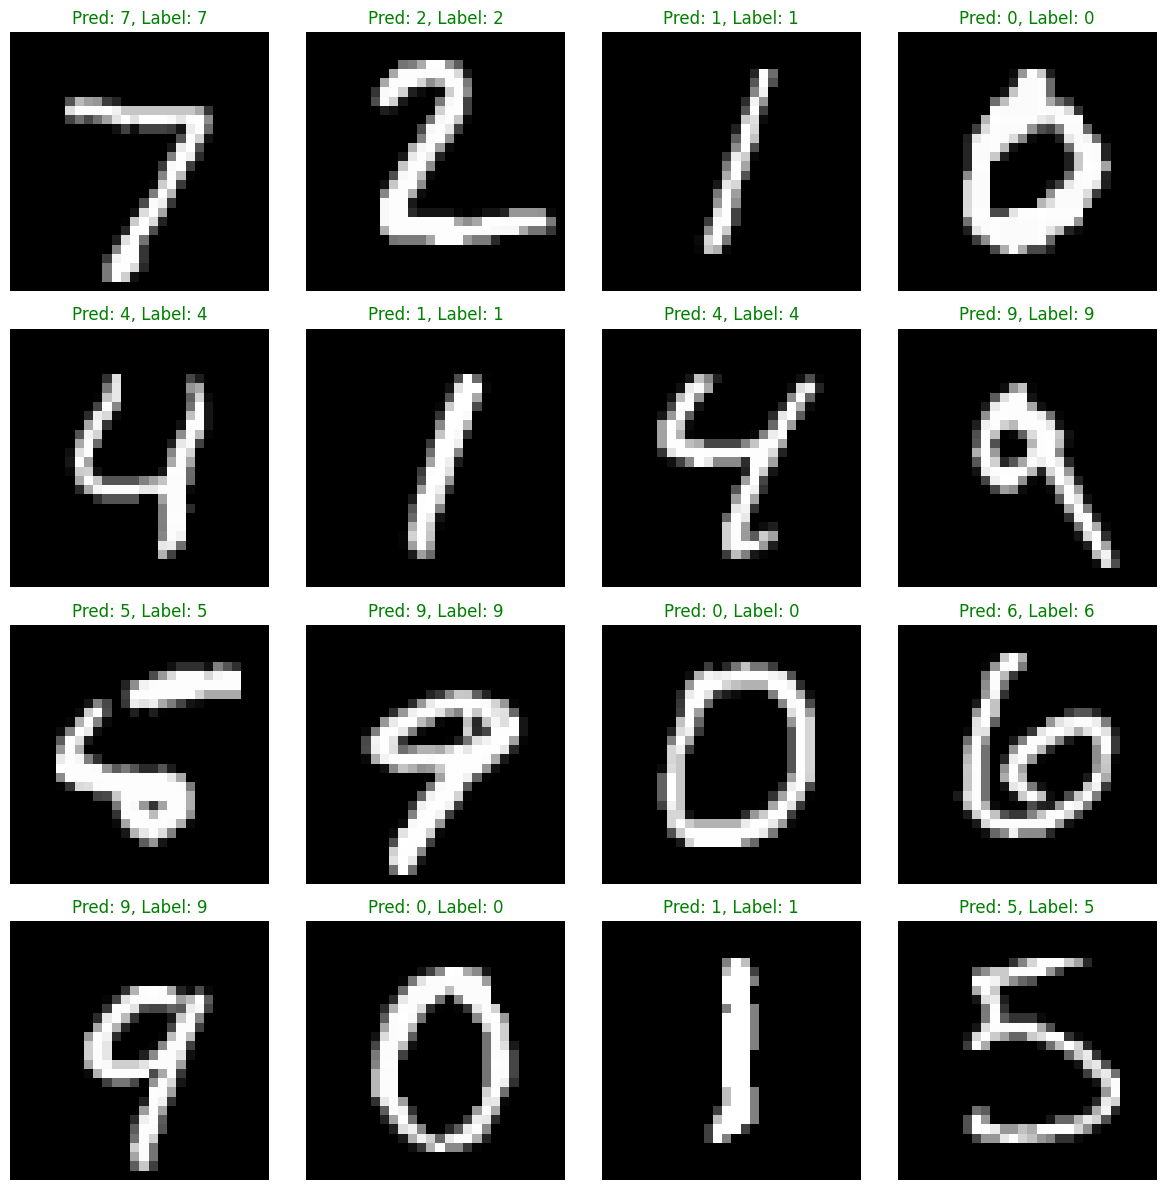

In [74]:
# Display predictions for a subset of images
plt.figure(figsize=(12, 12))
for i in range(16):
    plt.subplot(4, 4, i+1)
    img = images[i].cpu().squeeze().numpy()
    plt.imshow(img, cmap='gray')
    
    color = 'green' if predicted[i] == labels[i] else 'red'
    plt.title(f'Pred: {predicted[i].item()}, Label: {labels[i].item()}', color=color)
    plt.axis('off')
plt.tight_layout()
plt.show()

### Confusion Matrix

Let's create a confusion matrix to understand where our model is making errors:

In [75]:
# %%
# Compute the confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [76]:
# Get predictions for the entire test set
all_labels = []
all_preds = []

In [77]:
model_to_visualize.eval()
with torch.no_grad():
    for images, labels in test_loader:
        # @TODO
        images, labels = ....to(device), ....to(device)
        outputs = model_to_visualize(...)
        _, ... = torch....(..., 1)
        
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

In [78]:
# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)

In [79]:
# Normalize confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

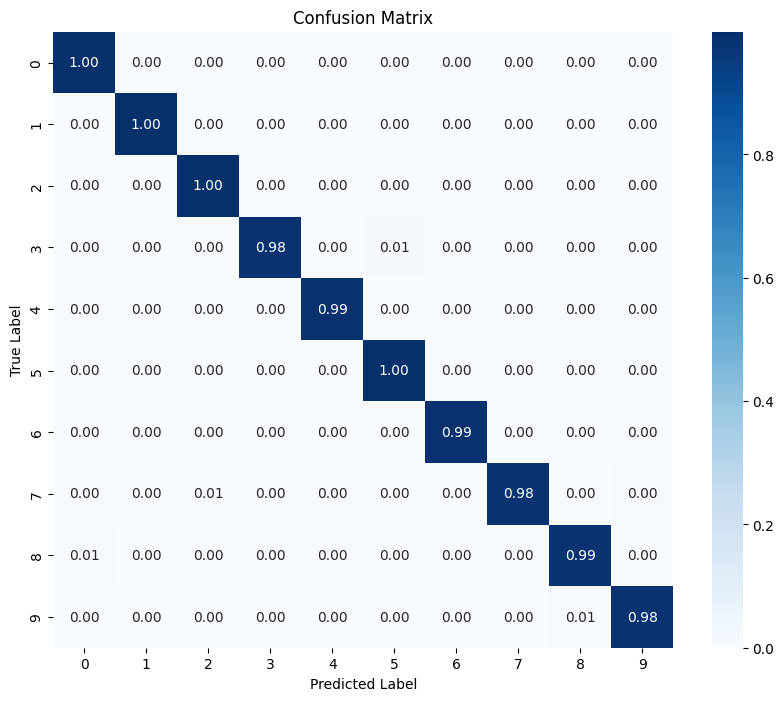

In [80]:
# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', 
            xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

## Conclusion

In this lab, we've explored the fundamentals of Convolutional Neural Networks using PyTorch. We've covered:

1. The basics of convolution operations and their implementation from scratch
2. Using PyTorch's built-in convolutional layers and related components
3. Building, training, and evaluating different CNN architectures
4. Visualizing filters, feature maps, and model predictions

CNNs are powerful models for image-related tasks due to their ability to learn spatial hierarchies of features. The skills learned in this lab can be extended to more complex architectures and applied to a variety of computer vision tasks.

## Exercises for Students

1. Modify the CNN architecture to achieve higher accuracy on the MNIST dataset.
2. Apply data augmentation techniques to improve model generalization.
3. Implement a CNN for a different dataset, such as CIFAR-10 (which has color images).
4. Create a visualization of the learned features at different layers.
5. Experiment with different optimizers and learning rates to see their impact on training.
6. Try implementing a more compact CNN architecture that achieves good performance with fewer parameters.